In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
import os
import collections
import string
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import re
import time

import tqdm
from tqdm import tqdm
from tqdm import trange

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils  import *

import numpy as np
from collections import Counter   # Dict subclass for counting hashable items

import pickle
from pickle import dump


import cv2

from text_utilities import *
from model_architecture import *

In [3]:
image_dir = '/content/drive/MyDrive/ImageCaptioning/Images'
images = os.listdir(image_dir)


print("The number of jpg files in Flicker8k: {}".format(len(images)-1))

The number of jpg files in Flicker8k: 8091


In [4]:
# For training and validation
path = '/content/drive/MyDrive/ImageCaptioning/Pickles/captions.pkl'


df = pickle.load(open(path, 'rb'))      # rb --> read binary
df.head(2)

caption  \
0  <start>  child in pink dress is climbing up se...   
1     <start>  girl going into wooden building <end>   

                      img_id  
0  1000268201_693b08cb0e.jpg  
1  1000268201_693b08cb0e.jpg

In [5]:
img_path = []
for i in range(len(df)):
  p = os.path.join(image_dir, df.iloc[i, 1])
  img_path.append(p)
df['img_path'] = img_path
df.head(2)

caption  \
0  <start>  child in pink dress is climbing up se...   
1     <start>  girl going into wooden building <end>   

                      img_id  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                            img_path  
0  /content/drive/MyDrive/ImageCaptioning/Images/...  
1  /content/drive/MyDrive/ImageCaptioning/Images/...

# Let's explore the dataframe

In [6]:
def utility_counter(df):

  unique_filenames = np.unique(df.img_path.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  return unique_filenames

In [7]:
unique_filenames = utility_counter(df)

The number of unique file names : 8000


# Let's plot images along with there captions

In [8]:
# https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html


def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))

  for image in unique_filenames[20:25]:
      captions = list(data["caption"].loc[data["img_path"]==image].values)
      image_load = load_img(image, target_size=target_size)

      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1

      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

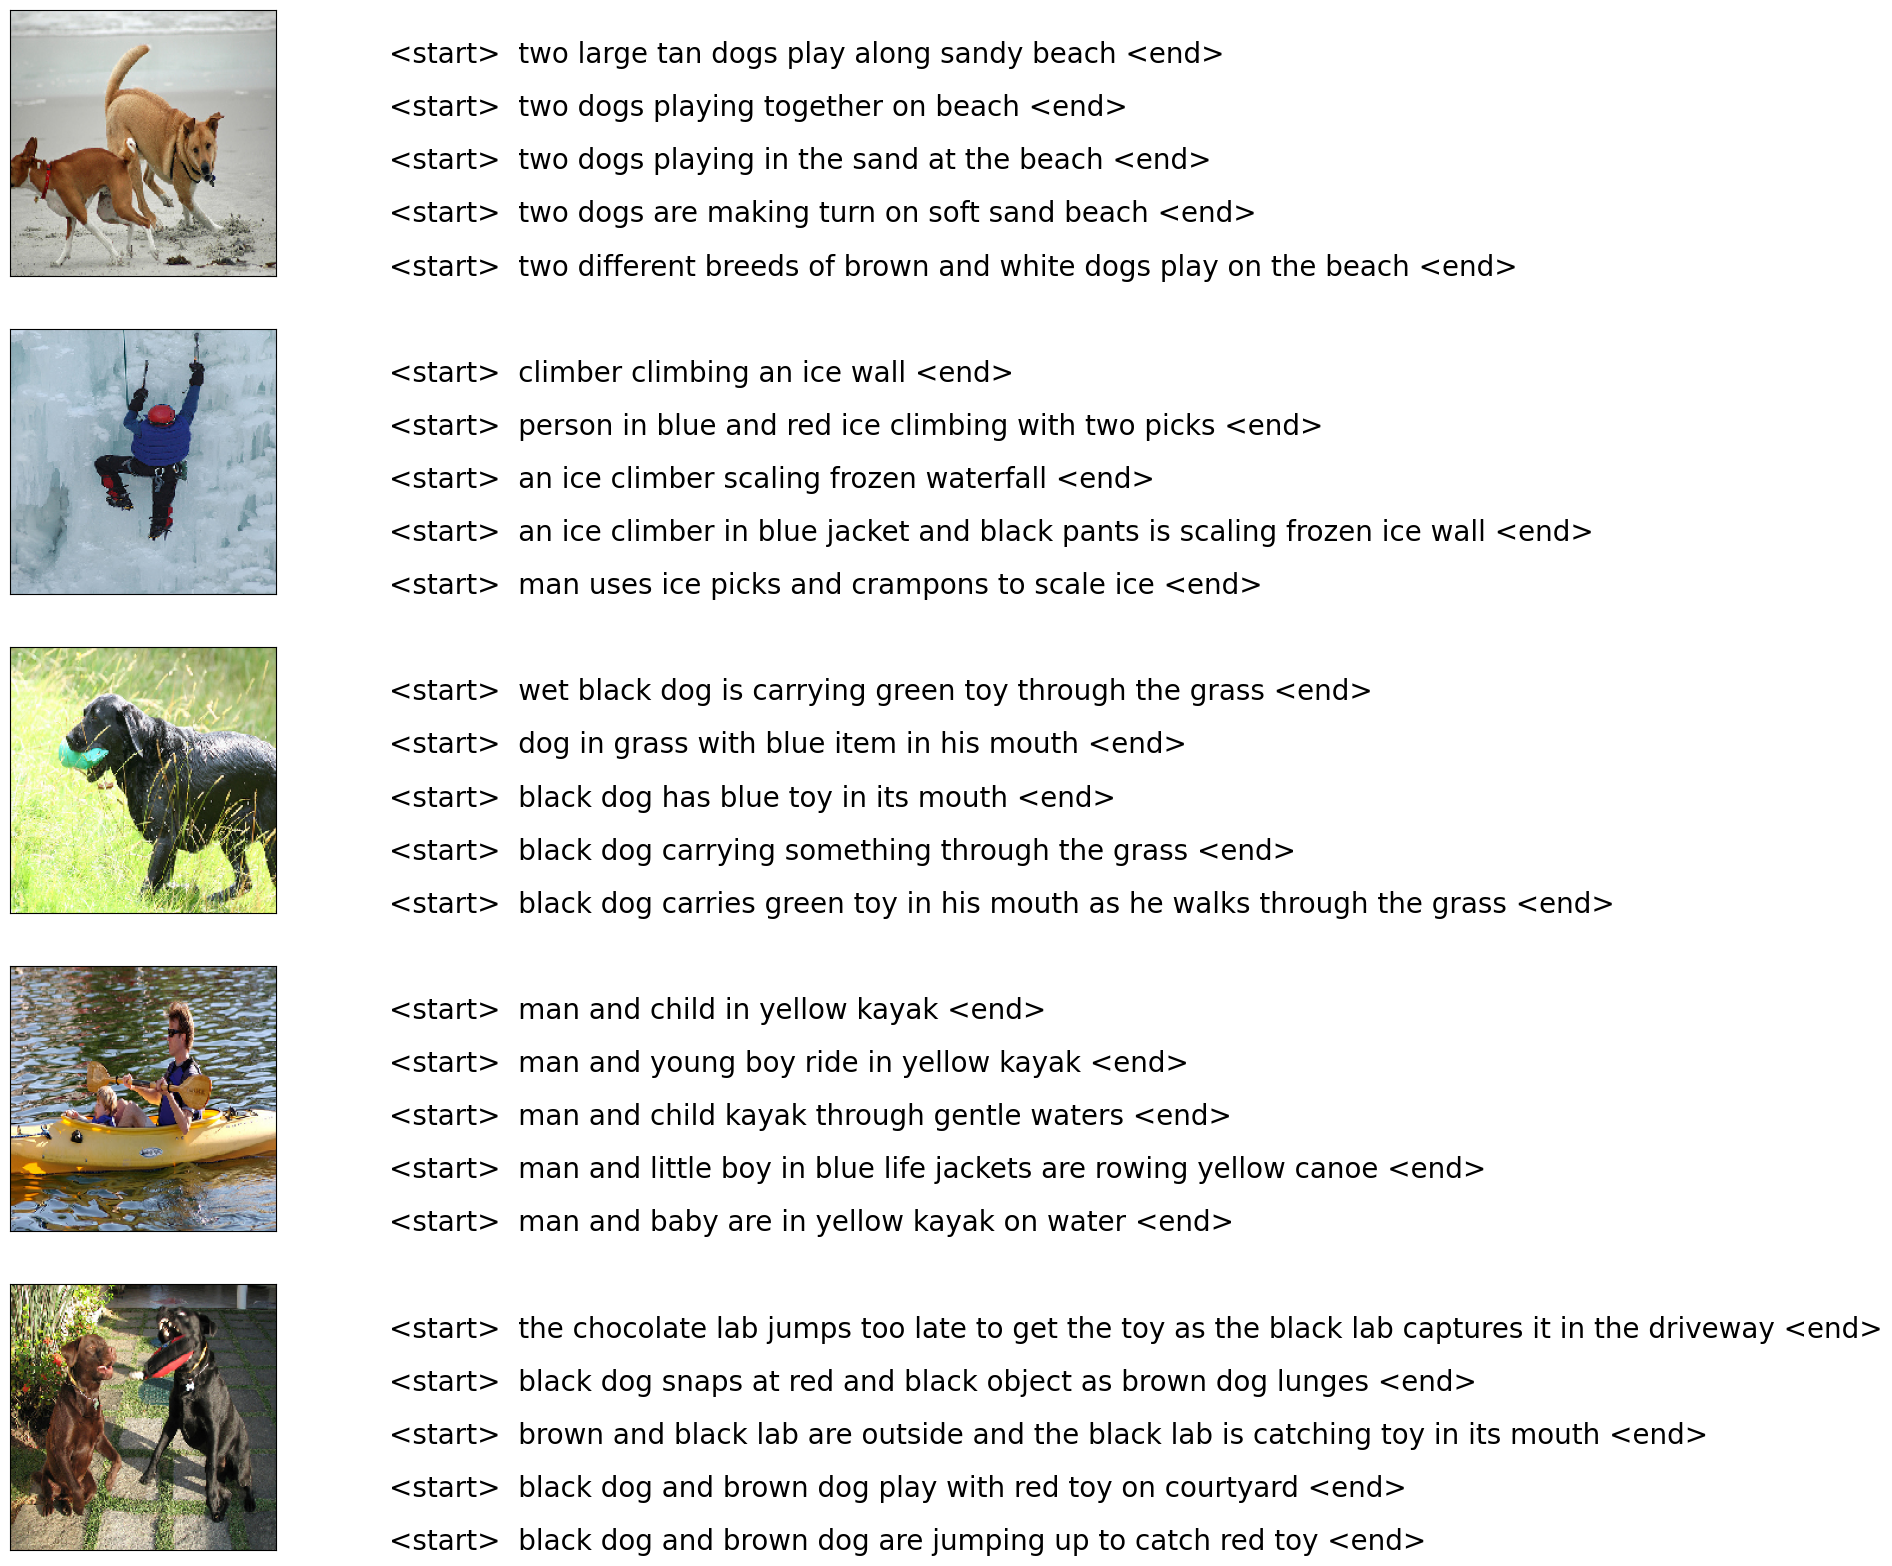

In [9]:
image_desc_plotter(df)

# Processing Captions

In [10]:
vocab , vocab_size, max_len = create_vocabulary(df, 0)

vocab_size, max_len

(8134, 31)

In [11]:
dfwordcount = df_word_count(vocab)

dfwordcount.iloc[:10]

word  count
0  <start>  40000
1    <end>  40000
2       in  17977
3      the  17305
4       on  10241
5       is   8957
6      and   7967
7      dog   7871
8     with   7232
9      man   7061

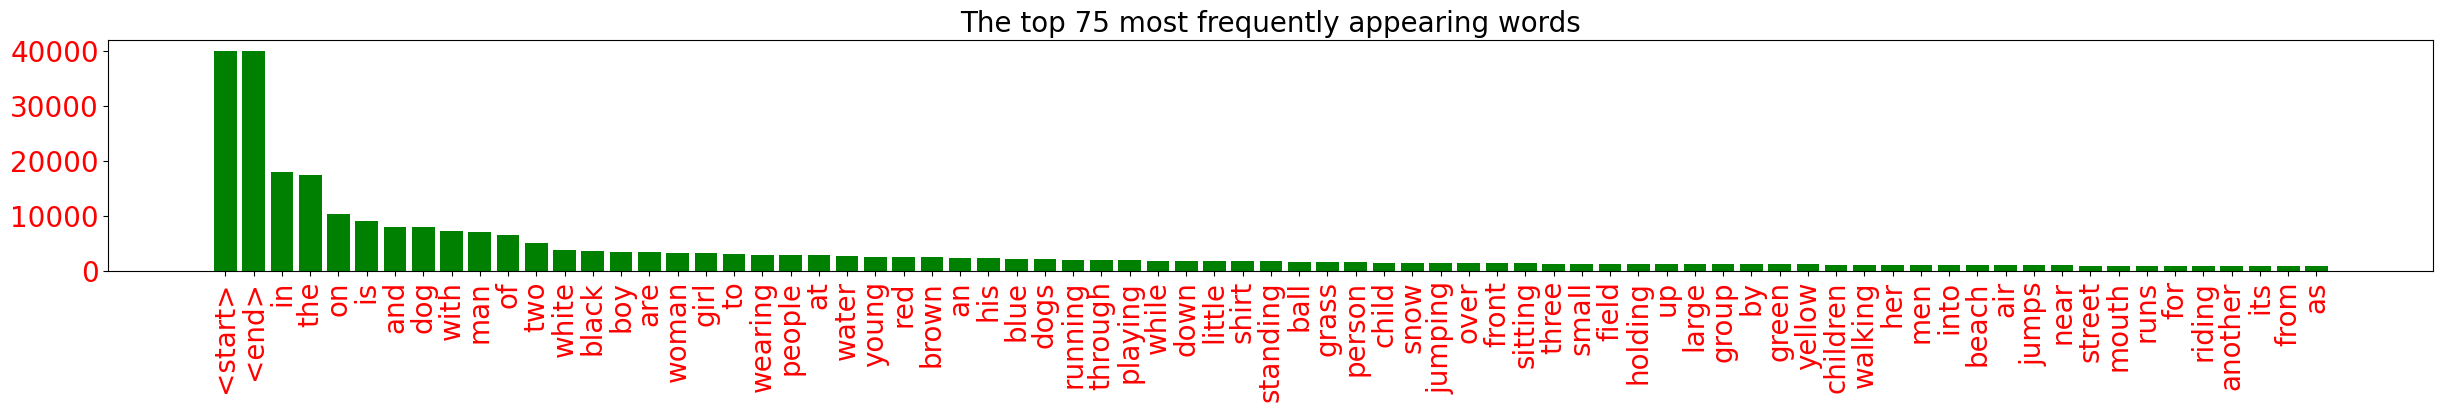

In [12]:
plt_histo(vocab)

# Tokenizer

In [13]:

tokenizer = Tokenizer( oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(list(df.iloc[:, 0]))

# Map ' ' to '0', to account for padding
tokenizer.word_index[' '] = 0
tokenizer.index_word[0] = ' '


In [14]:
pickle_out = open("/content/drive/MyDrive/ImageCaptioning/Pickles/Tokenizer.pkl","wb")
pickle.dump(tokenizer, pickle_out)
pickle_out.close()

In [15]:
unique_filenames[10]

'/content/drive/MyDrive/ImageCaptioning/Images/101654506_8eb26cfb60.jpg'

In [16]:
df.head(11)

caption  \
0   <start>  child in pink dress is climbing up se...   
1      <start>  girl going into wooden building <end>   
2   <start>  little girl climbing into wooden play...   
3   <start>  little girl climbing the stairs to he...   
4   <start>  little girl in pink dress going into ...   
5   <start>  black dog and spotted dog are fightin...   
6   <start>  black dog and dog playing with each o...   
7   <start>  black dog and white dog with brown sp...   
8   <start>  two dogs of different breeds looking ...   
9   <start>  two dogs on pavement moving toward ea...   
10  <start>  little girl covered in paint sits in ...   

                       img_id  \
0   1000268201_693b08cb0e.jpg   
1   1000268201_693b08cb0e.jpg   
2   1000268201_693b08cb0e.jpg   
3   1000268201_693b08cb0e.jpg   
4   1000268201_693b08cb0e.jpg   
5   1001773457_577c3a7d70.jpg   
6   1001773457_577c3a7d70.jpg   
7   1001773457_577c3a7d70.jpg   
8   1001773457_577c3a7d70.jpg   
9   1001773457_577c3a7d70.jpg   
10  1002674143_1b742ab4b8.jpg   

                                             img_path  
0   /content/drive/MyDrive/ImageCaptioning/Images/...  
1   /content/drive/MyDrive/ImageCaptioning/Images/...  
2   /content/drive/MyDrive/ImageCaptioning/Images/...  
3   /content/drive/MyDrive/ImageCaptioning/Images/...  
4   /content/drive/MyDrive/ImageCaptioning/Images/...  
5   /content/drive/MyDrive/ImageCaptioning/Images/...  
6   /content/drive/MyDrive/ImageCaptioning/Images/...  
7   /content/drive/MyDrive/ImageCaptioning/Images/...  
8   /content/drive/MyDrive/ImageCaptioning/Images/...  
9   /content/drive/MyDrive/ImageCaptioning/Images/...  
10  /content/drive/MyDrive/ImageCaptioning/Images/...

In [17]:
# path_features = '/content/drive/MyDrive/ImageCaptioning/Features'


# def encode_sequences (df):
#   in_tokens = []
#   out_tokens = []
#   img_path = []
#   # Create the tokenized vectors
#   for f in unique_filenames:
#     df_ = df.loc[df['img_path'] == f]
#     texts = df_['caption']

#     in_seqs = tokenizer.texts_to_sequences(texts)

#     in_seqs = pad_sequences(in_seqs, maxlen= max_len, padding='post')
#     out_seqs = in_seqs[:, 1:]
#     out_seqs = pad_sequences(out_seqs, maxlen= max_len, padding='post')

#     in_tokens.append(in_seqs)
#     out_tokens.append(out_seqs)

#     img_name = f.split('/')[-1][:-4]
#     path = os.path.join(path_features, img_name+'.npy')
#     img_path.append(path)

#   return img_path, in_tokens, out_tokens

# img_path, in_tokens , out_tokens = encode_sequences(df)
# in_tokens[0]

In [18]:
# pickle_out = open("/content/drive/MyDrive/ImageCaptioning/Pickles/vectorized_text.pickle","wb")
# pickle.dump((img_path, in_tokens , out_tokens), pickle_out)
# pickle_out.close()

In [19]:
pickle_in = open("/content/drive/MyDrive/ImageCaptioning/Pickles/vectorized_text.pickle","rb")
img_path, in_tokens , out_tokens = pickle.load(pickle_in)

In [20]:
tokenizer.word_index['girl']

19

# Let's see some image shapes

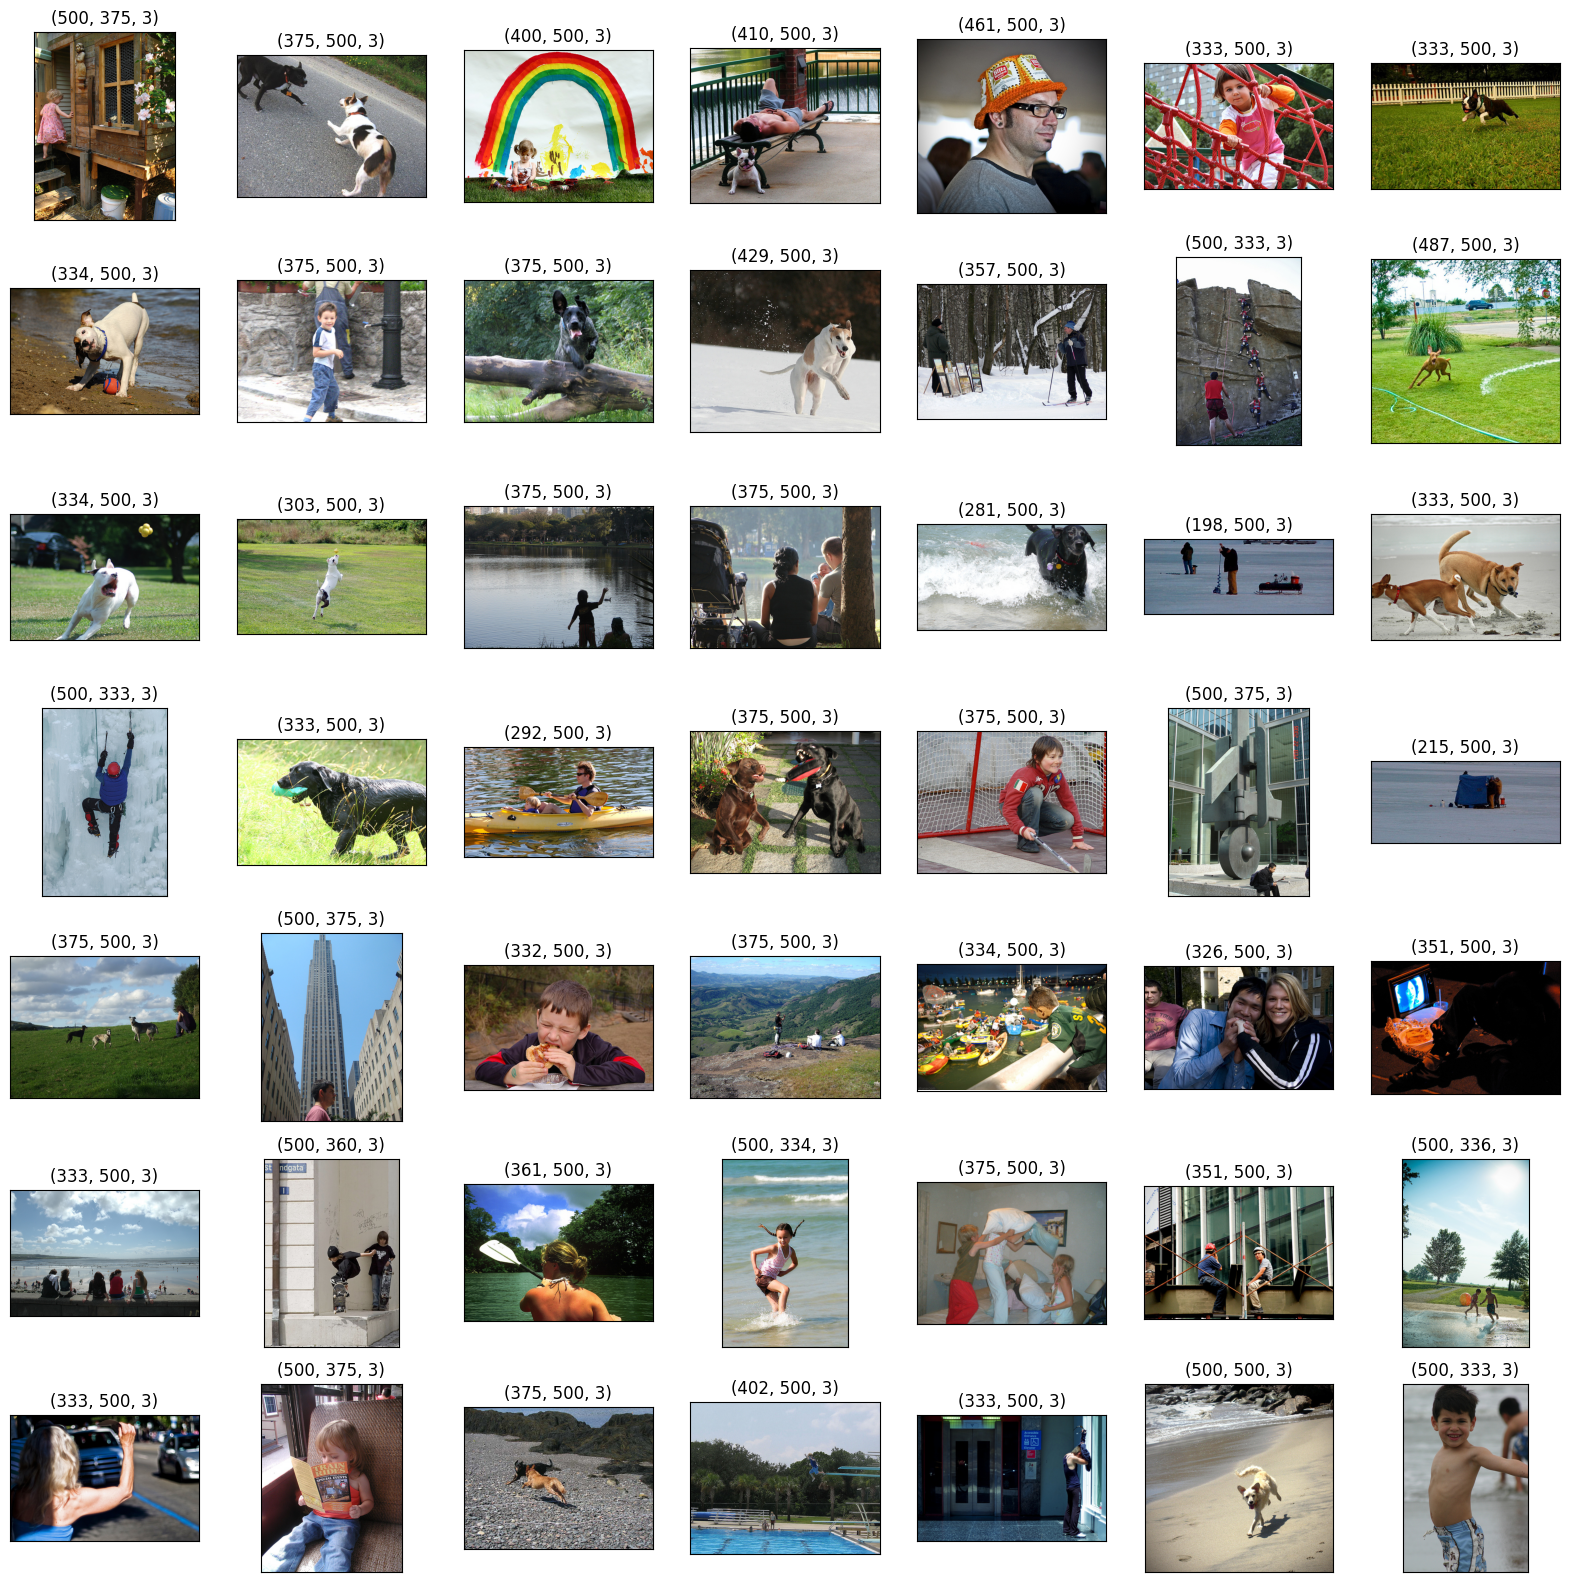

In [21]:
plt.figure(figsize=(20, 20))
for i in range (49):
  arr = plt.imread(unique_filenames[i])

  plt.subplot(7, 7, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title(arr.shape)
  plt.imshow(arr)

plt.show()

# Creating functions and trying Image Augmentation

Need to bring every image of shape (256,256,3) as we have used Resnet-50




# Image Histograms
Histogram is considered as a graph or plot which is related to frequency of pixels in an Gray Scale Image with pixel values (ranging from 0 to 255). Grayscale image is an image in which the value of each pixel is a single sample, that is, it carries only intensity information where pixel value varies from 0 to 255.

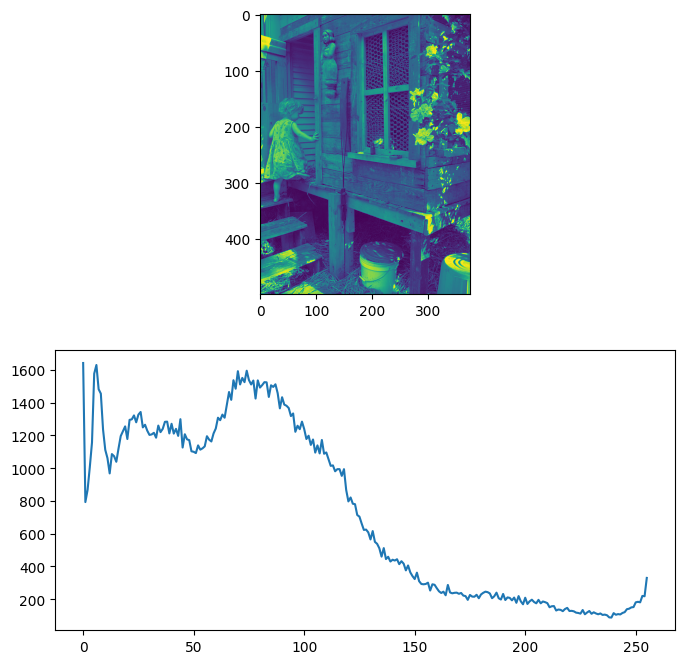

In [22]:
def plot_image_histograms(image):
  img = cv2.imread(image,0)
  # find frequency of pixels in range 0-255
  histr = cv2.calcHist([img],[0],None,[256],[0,256])

  # show the plotting graph of an image
  fig = plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.imshow(img)
  plt.subplot(2,1,2)
  plt.plot(histr)
  plt.show()

plot_image_histograms(df["img_path"].iloc[1])

# Pre-Trained Image Model (Resnet50)

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

We will use some of the fully-connected layers in this pre-trained model, so we have to download the full model, but if you have a slow internet connection, then you can try and modify the code below to use the smaller pre-trained model without the classification layers.

Normally, the CNN's last layer is the softmax layer, which assigns the probability that each object might be in the image. But, if we remove that softmax layer from CNN, we can feed the CNN's rich encoding of the image into the DECODER(language generation of RNN) designed to produce phrases. We can then train the whole system directly on images and their captions, so it maximizes the likelihood that the descriptions it produces best match the training descriptions for each image

In [23]:
# image_model = tf.keras.applications.resnet50.ResNet50(
#                                                       include_top=False,
#                                                       weights='imagenet',
#                                                       input_shape = (256, 256, 3)
#                                                       )
# image_model.trainable = False

# new_input = image_model.input                 # Any arbitrary shapes with 3 channels
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [24]:
# tf.keras.utils.plot_model(
#     image_features_extract_model,
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_activations=True,
#     show_trainable=True,
# )

In [25]:

# def load_image(img_path):
#     img = tf.io.read_file(img_path)           # returns tensor of dtype "string", with the file contents.
#     img = tf.image.decode_jpeg(img, channels=3)   # returns tensor of type uint8.
#     img = tf.image.resize(img, (256, 256))
#     return img, img_path

# img1, path = load_image(df["img_path"].iloc[1001])
# print((img1.shape))
# path

In [26]:
# path = '/content/drive/MyDrive/ImageCaptioning/Features'

# batch_sz = 16
# #_______________________________________________________________________________________
# image_dataset = tf.data.Dataset.from_tensor_slices(unique_filenames)

# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_sz)

# #________________________________________________________________________________________
# for img, path_ in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))    # (batch_sz , 49, 2048)

#   for bf, p in zip(batch_features, path_):
#     path_of_feature = os.path.join(path , p.numpy().decode("utf-8").split('/')[-1][:-4])
#     np.save(path_of_feature, bf.numpy())

# Train- Validation Split (80:20)

In [27]:
from sklearn.model_selection import train_test_split

# Create training and test set using an 80-20 split
X_tr_img, X_tst_img, X_tr_token, X_tst_token, Y_tr_label, Y_tst_label = train_test_split(img_path, in_tokens , out_tokens,test_size=0.2,random_state=0)

print("Training Data : X_tr_img = {0}, X_tr_token = {1}, Y_tr_label= {2}".format(len(X_tr_img), len(X_tr_token), len(Y_tr_label)))
print("Training Data : X_tst_img = {0}, X_tst_token = {1}, Y_tst_label= {2}".format(len(X_tst_img), len(X_tst_token), len(Y_tst_label)))


Training Data : X_tr_img = 6400, X_tr_token = 6400, Y_tr_label= 6400
Training Data : X_tst_img = 1600, X_tst_token = 1600, Y_tst_label= 1600


In [28]:
X_tr_img[100]

'/content/drive/MyDrive/ImageCaptioning/Features/848180689_d67a1361ce.npy'

In [29]:
X_tst_token[1]

array([[   2,   19,    8,  101, 1004,  184,  219,    5,   24,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   37,   19,    7, 5644,  104,   13, 1004,   23,    5,  121,
          12,  255,  413,    5,  127,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   42, 2391,  104,  101, 1004,    6,    5,   24,   20,  179,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,  108,  268,   13, 1360,   67,    5,  127,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   19,   10,   13, 1004,    6,  255,  413,    5,   24,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

In [30]:
Y_tst_label[1]

array([[  19,    8,  101, 1004,  184,  219,    5,   24,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  37,   19,    7, 5644,  104,   13, 1004,   23,    5,  121,   12,
         255,  413,    5,  127,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  42, 2391,  104,  101, 1004,    6,    5,   24,   20,  179,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  18,  108,  268,   13, 1360,   67,    5,  127,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  19,   10,   13, 1004,    6,  255,  413,    5,   24,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

# Creating dataset
Loading the .npy files

In [31]:
path = '/content/drive/MyDrive/ImageCaptioning/Features'

def load_npy(img_name, in_token, out_token):
  p = img_name.decode('utf-8')
  img_tensor = np.load(p)
  return img_tensor, in_token, out_token

In [32]:
BATCH_SIZE = 2
BUFFER_SIZE = 500

In [33]:
'''
  .from_tensor_slices --->
       @ Represents a potentially large set of elements
       @ Iteration happens in streaming fashion, so the full dataset does not need to fit into memory.

  num_parallel_calls --->
       @ representing the number of batches to compute asynchronously in parallel.
       @ If not specified, batches will be computed sequentially.
       @ If value (tf.data.AUTOTUNE) used, then the no. of parallel calls is set dynamcally based on avalble resources.

  .batch --->
       @ A tf.int64 scalar tf.Tensor, representing the no. of consecutive elements
       @ of this dataset to combine in a single batch.

  .map  --->
       @ applies map_func to each element of this dataset, and returns new dataset
              containing transformed elements, in the same order as they appeared in the input.
       @ can be used to change both the values and the structure of a dataset's elements

  .shuffle -->
        @ Instead of shuffling the entire dataset, it maintains a buffer of buffer_size elements,
            and randomly selects the next element from that buffer (replacing it with the next input element, if one is available).
        @ Changing the value of buffer_size affects how uniform the shuffling is: if buffer_size is greater than the number of
            elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all.
        @ For very large datasets, a typical "good enough" approach is to randomly shard the data into multiple files once
            before training, then shuffle the filenames uniformly, and then use a smaller shuffle buffer.
        @ However, the appropriate choice will depend on the exact nature of your training job.
'''

def create_dataset(img, in_token, out_token):

  dataset = tf.data.Dataset.from_tensor_slices((img, in_token, out_token))


  dataset = dataset.map (lambda item1, item2, item3: tf.numpy_function(load_npy, [item1, item2, item3] , [tf.float32, tf.int32, tf.int32]),
                                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Shuffle and batch
  dataset = dataset.batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset



In [34]:
# Creating train and test dataset

train_dataset = create_dataset(X_tr_img , X_tr_token, Y_tr_label)
val_dataset = create_dataset(X_tst_img, X_tst_token, Y_tst_label)

train_dataset.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int32, name=None),
 TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))

In [35]:
len(train_dataset)

3200

In [36]:
embedding_dim = 256
units = 256
captions_per_image = 5
num_steps = len(train_dataset)
EPOCHS = 1
vocab_size += 2      # +1 for padding, +1 for <unk>
# Shape from last layer of Resnet :(7,7,2048)
# So, say there are 49 pixel locations now and each pixel is 2048 dimensional

features_shape = 2048
attention_features_shape = 64

In [37]:
model = Captioner(max_length = max_len, vocab_size= vocab_size,tokenizer = tokenizer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)


Uniform entropy: 9.00
Marginal entropy: 5.69


# Train
To train the model you'll need several additional components:

*   The Loss and metrics
*   The Optimizer
*   Optional Callbacks
*   Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the loss < 1e8. This term discards the artificial, impossibly high losses for the banned_tokens.

In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


@tf.function
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)    #  between logits (Unscaled log probabilities) and labels.

  # only consider those losses which have
  # decent prob of occurrence for that word at that position
  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss
#_______________________________________________________________________________

@tf.function
def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match_ = tf.cast(preds == labels, mask.dtype)

  # how many words at same location in preds wrt labels
  acc = tf.reduce_sum(match_*mask)/tf.reduce_sum(mask)
  return acc

def meteor():
  pass

In [39]:
model.compile(optimizer = optimizer)

# Saving Checkpoint
TensorFlow objects provide an easy automatic mechanism for saving and restoring the values of variables they use.

All prefixes are grouped together in a single checkpoint file ('./tf_ckpts/checkpoint') where the CheckpointManager saves its state.

In [40]:
checkpoint_path_ckpt = "/content/drive/MyDrive/ImageCaptioning/img_cap_ckpt"
if not os.path.isdir(checkpoint_path_ckpt):
  os.mkdir(checkpoint_path_ckpt)

ckpt = tf.train.Checkpoint(model = model,
                           optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=2)

Start checkpointing from the checkpoint last saved

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [42]:
checkpoint_path = ckpt_manager.latest_checkpoint
ckpt.restore(checkpoint_path)

# Setup Tensorboard summary writer

In [43]:
# # Clear previous logs
# !rm -rf ./logs/

# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

In [44]:
# import datetime

# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
# test_log_dir = 'logs/gradient_tape/' + current_time + '/test'

# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# Applying Gradient_descent
 Evaluating loss , updating model_parameters

In [45]:

@tf.function
def train_step(img_tensor, in_token, target):
  loss = 0
  acc  = 0
  # meteor = 0


  with tf.GradientTape() as tape:
    for i in range(captions_per_image):
      tokens = in_token[:,i, : ]
      preds_i = model((img_tensor, tokens))

      acc += masked_acc(target[:, i, :], preds_i)
      loss += masked_loss(target[:, i, :], preds_i)
    # meteor =


  trainable_variables =  model.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, acc

In [46]:

@tf.function
def test_step(img_tensor, in_token, target):
  loss = 0
  acc = 0
  for i in range(captions_per_image):

      preds_i = model((img_tensor, in_token[:,i, : ]))


      acc += masked_acc(target[:, i, :], preds_i)
      loss += masked_loss(target[:, i, :], preds_i)
    # meteor =


  return loss, acc

In [47]:
pickle_in = open("/content/drive/MyDrive/ImageCaptioning/Pickles/plots.pickle","rb")
train_loss_plot, test_loss_plot , train_acc_plot, test_acc_plot = pickle.load(pickle_in)

# Training Model

In [ ]:
epoch = 0
for i in range(2):

    start = time.time()

    #For Train
    #================================================================
    total_loss_train = 0
    total_acc_train = 0
    for  i, (img_tensor,in_token,  target) in enumerate(train_dataset) :

        batch_loss, batch_acc = train_step(img_tensor, in_token, target)     # img_tensor : (10 , 49 , 512)
        total_loss_train += batch_loss
        total_acc_train += batch_acc



    # storing the epoch end loss value to plot later
    train_loss_plot.append(total_loss_train / num_steps)
    train_acc_plot.append(total_acc_train /num_steps)

    # Tensorboard
    # with train_summary_writer.as_default():
    #   tf.summary.scalar('LossPlotTrain', (total_loss_train/ num_steps), step=epoch)
    #   tf.summary.scalar('Train_loss', train_loss.result(), step=epoch)

    #For Test
    #================================================================
    total_loss_test = 0
    total_acc_test = 0
    for i,(img_tensor, in_token ,target) in enumerate(val_dataset):
        batch_loss, batch_acc = test_step(img_tensor, in_token, target)
        total_loss_test += batch_loss
        total_acc_test += batch_acc


    # storing the epoch end loss value to plot later
    test_loss_plot.append(total_loss_test / num_steps)
    test_acc_plot.append(total_acc_test/num_steps)

    # Tensorboard
    # with test_summary_writer.as_default():
    #   tf.summary.scalar('LossPlotTest', (total_loss_test/ num_steps), step=epoch)



    ckpt_manager.save()
    epoch += 1

    print ('Epoch : {}   TrainLoss : {:.5f}   TestLoss : {:.5f}'.format(epoch + 1,(total_loss_train/num_steps),(total_loss_test/num_steps)), end= '')
    print ('   TrainAcc : {:.5f}   TestAcc : {:.5f}'.format((total_acc_train/num_steps),(total_acc_test/num_steps)), end= '')

    print ('    Time : {:.2f} sec\n'.format(time.time() - start))

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    show_trainable=True,
)

In [ ]:
pickle_out = open("/content/drive/MyDrive/ImageCaptioning/Pickles/plots.pickle","wb")
pickle.dump((train_loss_plot, test_loss_plot , train_acc_plot, test_acc_plot), pickle_out)
pickle_out.close()

In [ ]:
from keras.models import load_model

model.save_weights('/content/drive/MyDrive/ImageCaptioning/model_weights' ,save_format='tf')  # creates a HDF5 file 'my_model.h5'

# Launching Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

# Plot the Train and Validation Losses to check for overfitting

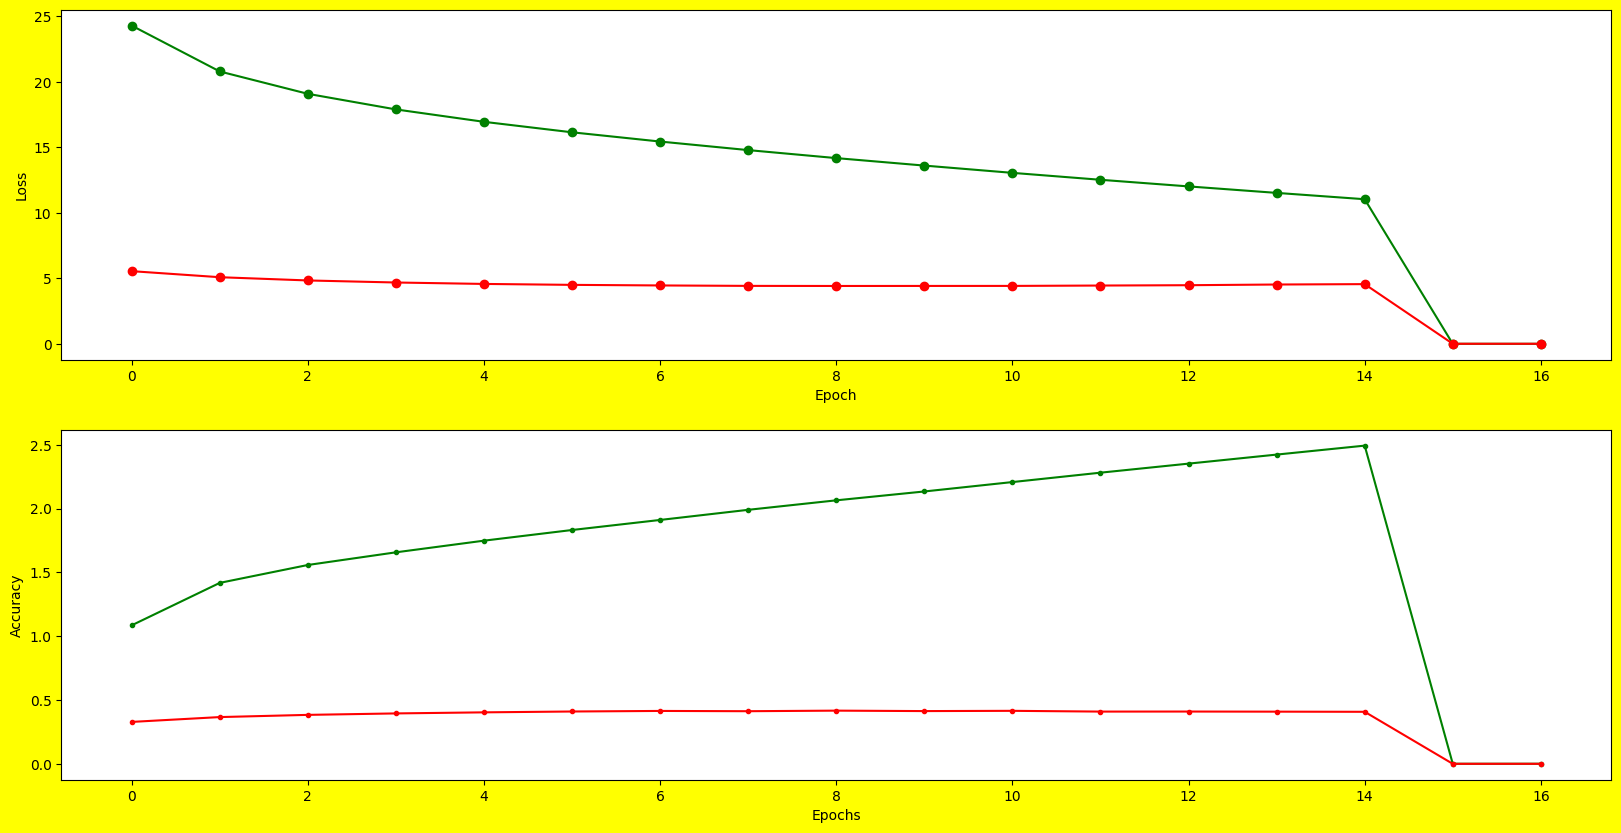

In [49]:
plt.figure( figsize=(20,10), facecolor='yellow')

plt.subplot(2, 1, 1)
plt.plot(train_loss_plot, 'o-', color='green')
plt.plot(test_loss_plot, 'o-', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')



plt.subplot(2, 1, 2)
plt.plot(train_acc_plot, '.-', color='green')
plt.plot(test_acc_plot, '.-', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()